In [1]:
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.utils.data import DataLoader

from score_models.trainer import trainer
from score_models.models.mlp import MLPScoreModel
from score_models.train_steps import TrainStepNCSN
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_sigmas
from score_models.utils.visualisations import plot_gradient_field
from score_models.sampling import annealed_langevin_dynamics

In [2]:
# load dataset
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [3]:
device = "cuda"
input_size = 2
hidden_size = 32
L = 10
lr = 1e-4

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, T=L).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=lr)

# define train step (i.e., criterion)
sigma_min, sigma_max = 1.0, 20.0
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)
train_step = TrainStepNCSN(score_model=score_model, sigmas=sigmas)


In [4]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    device=device,
    num_steps=20000,
    log_every=1000,
    save_every=5000,
)

  5%|▌         | 1037/20000 [00:03<01:03, 300.17it/s]

Step 1000, Loss: 1.1002


 10%|█         | 2034/20000 [00:07<00:58, 306.59it/s]

Step 2000, Loss: 0.8868


 15%|█▌        | 3044/20000 [00:10<00:52, 326.07it/s]

Step 3000, Loss: 0.7987


 20%|██        | 4035/20000 [00:13<00:56, 280.22it/s]

Step 4000, Loss: 0.8056


 25%|██▌       | 5051/20000 [00:17<00:52, 282.92it/s]

Step 5000, Loss: 0.6994


 30%|███       | 6032/20000 [00:20<00:50, 278.95it/s]

Step 6000, Loss: 0.6855


 35%|███▌      | 7043/20000 [00:24<00:45, 283.68it/s]

Step 7000, Loss: 0.6234


 40%|████      | 8033/20000 [00:27<00:42, 281.29it/s]

Step 8000, Loss: 0.5898


 45%|████▌     | 9049/20000 [00:31<00:38, 284.77it/s]

Step 9000, Loss: 0.6167


 50%|█████     | 10039/20000 [00:34<00:34, 287.95it/s]

Step 10000, Loss: 0.5834


 55%|█████▌    | 11045/20000 [00:38<00:31, 284.28it/s]

Step 11000, Loss: 0.6079


 60%|██████    | 12048/20000 [00:41<00:27, 285.23it/s]

Step 12000, Loss: 0.5685


 65%|██████▌   | 13035/20000 [00:45<00:24, 282.03it/s]

Step 13000, Loss: 0.5671


 70%|███████   | 14054/20000 [00:48<00:20, 285.67it/s]

Step 14000, Loss: 0.5743


 75%|███████▌  | 15049/20000 [00:52<00:17, 277.30it/s]

Step 15000, Loss: 0.5319


 80%|████████  | 16056/20000 [00:56<00:14, 279.18it/s]

Step 16000, Loss: 0.5748


 85%|████████▌ | 17034/20000 [00:59<00:10, 284.01it/s]

Step 17000, Loss: 0.5936


 90%|█████████ | 18050/20000 [01:03<00:06, 282.11it/s]

Step 18000, Loss: 0.5527


 95%|█████████▌| 19035/20000 [01:06<00:03, 285.98it/s]

Step 19000, Loss: 0.5640


100%|██████████| 20000/20000 [01:10<00:00, 285.71it/s]


Step 20000, Loss: 0.5550


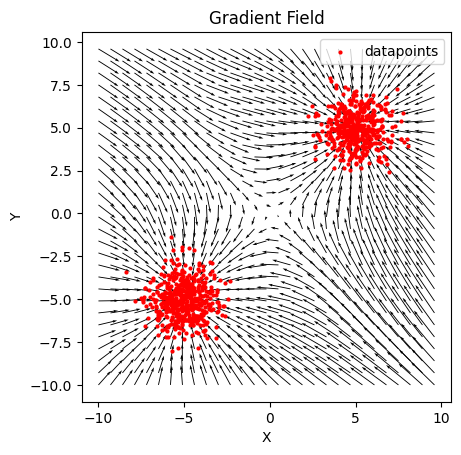

In [5]:
plot_gradient_field(score_model=score_model, i=L-1, datapoints=dataset[:1000])

In [8]:
# sample some datapoints
samples = annealed_langevin_dynamics(
    score_model=score_model, 
    input_size=(500, 2), 
    sigmas=sigmas, 
    r=(-8, 8), 
    T=100,
    eps=0.1,
).cpu().numpy()

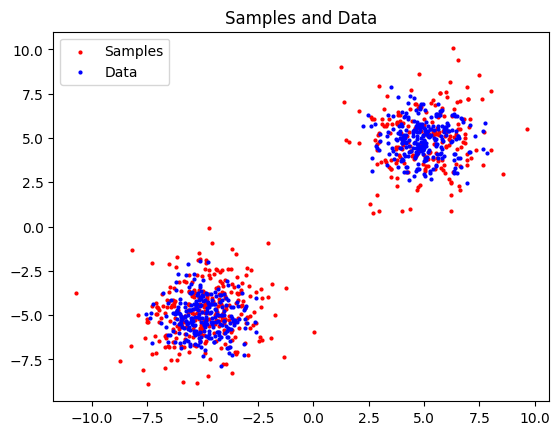

In [11]:
# plot original data and samples
ax = plt.gca()
ax.scatter(samples[:, 0], samples[:, 1], color='red', s=4, label='Samples')
ax.scatter(dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data')
ax.set_title('Samples and Data')
plt.legend();